### 1.预处理
读文件、预处理数据、获取统计信息、得到训练集、验证集和测试集。

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('winequalityN.csv')
print(df.head())

    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.4

In [136]:
df['type'] = df['type'].apply(lambda x : 1 if x == 'white' else 0)

In [137]:
df = df.dropna(how='any')       # 删掉含至少一个空值的行
for key in df.keys():
    print(f"{df[key].max():.2f},{df[key].min():.2f},{df[key].mean():.2f},{df[key].std():.2f},{df[key].median():.2f}")
# df.iloc[:, :-1] = df.iloc[:, :-1].apply(lambda x : ((x - np.min(x)) / (np.max(x) - np.min(x))))   # 归一化
df.iloc[:, :-1] = df.iloc[:, :-1].apply(lambda x : ((x - np.mean(x)) / (np.std(x))))   # 标准化

1.00,0.00,0.75,0.43,1.00
15.90,3.80,7.22,1.30,7.00
1.58,0.08,0.34,0.16,0.29
1.66,0.00,0.32,0.15,0.31
65.80,0.60,5.44,4.76,3.00
0.61,0.01,0.06,0.04,0.05
289.00,1.00,30.52,17.76,29.00
440.00,6.00,115.69,56.53,118.00
1.04,0.99,0.99,0.00,0.99
4.01,2.72,3.22,0.16,3.21
2.00,0.22,0.53,0.15,0.51
14.90,8.00,10.49,1.19,10.30
9.00,3.00,5.82,0.87,6.00


In [138]:
n_all = df.shape[0]
n_train = int(n_all * 0.6)
n_dev = int(n_all * 0.2)
n_test = n_all - n_train - n_dev
m = 12
print(f"n_all={n_all}, n_train={n_train}, n_dev={n_dev}, n_test={n_test}")

n_all=6463, n_train=3877, n_dev=1292, n_test=1294


In [139]:
idx = np.arange(n_all)
np.random.seed(114514)
np.random.shuffle(idx)
df = df.iloc[idx]
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3672,0.571931,0.063372,0.427700,-0.197999,-0.766103,-0.685882,-0.254365,-0.737664,-1.935111,-1.608168,-1.216570,2.101508,8
3866,0.571931,0.910952,-0.665684,0.008554,-0.871223,-0.229692,1.604011,-0.047671,-0.972167,-0.736640,0.126596,0.425113,6
4645,0.571931,-1.708841,-0.604940,0.146257,-0.913271,-0.628858,1.040867,0.748474,-2.318290,0.632903,-1.418045,2.185328,7
4610,0.571931,-1.015366,0.609931,0.283959,-0.618936,-0.742906,-1.042767,-0.755356,-0.895531,0.010383,-0.343512,0.257473,6
113,0.571931,-0.398944,0.427700,0.146257,0.789668,-0.201180,-0.085421,0.606937,0.700491,0.010383,-0.142037,-1.167463,5


In [140]:
X_train, Y_train = df.iloc[:n_train, :-1], df.iloc[:n_train, -1:]
X_dev, Y_dev = df.iloc[n_train:n_train+n_dev, :-1], df.iloc[n_train:n_train+n_dev, -1:]
X_test, Y_test = df.iloc[n_train+n_dev:n_all, :-1], df.iloc[n_train+n_dev:n_all, -1:]
print(f"{X_train.shape},{Y_train.shape},{X_dev.shape},{Y_dev.shape},{X_test.shape},{Y_test.shape}")

(3877, 12),(3877, 1),(1292, 12),(1292, 1),(1294, 12),(1294, 1)


In [141]:
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy().squeeze()
X_dev = X_dev.to_numpy()
Y_dev = Y_dev.to_numpy().squeeze()
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy().squeeze()

### 2.实现算法, 调超参数

In [142]:
def calc_dis(x1, x2):
    return np.sqrt(np.sum(np.square(x1 - x2)))

def predict(x, k):
    dis_list = []
    for i in range(n_train):
        dis_list.append((calc_dis(X_train[i], x), Y_train[i]))
    dis_list.sort(key=(lambda a : a[0]))
    dis_list = dis_list[:k]
    dis_list = [a[1] for a in dis_list]
    return max(set(dis_list), key=dis_list.count)


In [143]:
for j in range(10):
    print(f"Y_train={Y_train[j]},Y_pred={predict(X_train[j], 20)}")     # 稍微测试下能不能跑起来

Y_train=8,Y_pred=6
Y_train=6,Y_pred=6
Y_train=7,Y_pred=7
Y_train=6,Y_pred=6
Y_train=5,Y_pred=5
Y_train=7,Y_pred=6
Y_train=6,Y_pred=6
Y_train=6,Y_pred=6
Y_train=7,Y_pred=6
Y_train=6,Y_pred=6


In [144]:
k_x = range(1, 31)
k_y = []
for k in k_x:
    correct_cnt = 0
    for i in range(n_dev):
        y_pred = predict(X_dev[i], k)
        if Y_dev[i] == y_pred:
            correct_cnt += 1
    print(f"k={k}, correct_rate={correct_cnt / n_dev}")
    k_y.append(correct_cnt / n_dev)

k=1, correct_rate=0.6075851393188855
k=2, correct_rate=0.5356037151702786
k=3, correct_rate=0.5286377708978328
k=4, correct_rate=0.5557275541795665
k=5, correct_rate=0.5464396284829721
k=6, correct_rate=0.554953560371517
k=7, correct_rate=0.5626934984520123
k=8, correct_rate=0.5557275541795665
k=9, correct_rate=0.5487616099071208
k=10, correct_rate=0.5425696594427245
k=11, correct_rate=0.541795665634675
k=12, correct_rate=0.5433436532507739
k=13, correct_rate=0.5479876160990712
k=14, correct_rate=0.5464396284829721
k=15, correct_rate=0.5472136222910217
k=16, correct_rate=0.5402476780185759
k=17, correct_rate=0.5441176470588235
k=18, correct_rate=0.5379256965944272
k=19, correct_rate=0.5464396284829721
k=20, correct_rate=0.5386996904024768
k=21, correct_rate=0.5270897832817337
k=22, correct_rate=0.5286377708978328
k=23, correct_rate=0.5325077399380805
k=24, correct_rate=0.5301857585139319
k=25, correct_rate=0.5286377708978328
k=26, correct_rate=0.5386996904024768
k=27, correct_rate=0.53

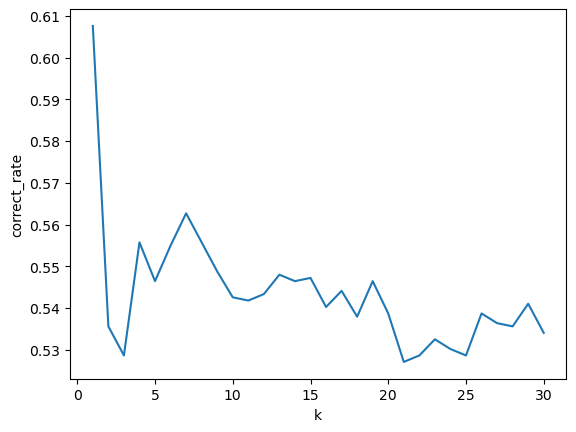

In [145]:
plt.xlabel("k")
plt.ylabel("correct_rate")
plt.plot(k_x, k_y)

### 3.评估
在测试集上计算准确率。

In [146]:
def evaluate(k):
    correct_cnt = 0
    for i in range(n_test):
        y_pred = predict(X_test[i], k)
        if Y_test[i] == y_pred:
            correct_cnt += 1
    print(f"correct_cnt={correct_cnt}")
    return correct_cnt / n_test

In [147]:
evaluate(1)

correct_cnt=762


0.58887171561051